# Problem set 3 -- Neural Amortized Inference

Save the completed notebook as a pdf file and submit the pdf file to Canvas. Follow examples in the `Data-Driven Proposals in Gen` notebook (Section 5) covered in the lecture.

In [71]:
using Random
using Gen
using Plots
using DelimitedFiles
using JLD2

## Perception in a rectangle world

In this pset, you will develop a perception system that operates in a two-dimensional grayscale world where all objects are axis-aligned rectangular frames (i.e., unfilled rectangles) and there is just one such object in a given scene. An example scene in this world is illustrated below. Given such an input, the perception system should provide a posterior over where the object is, its constrast and size.

<img src="./images/examples.png"  width="500"/>

### Q 1A [2.5 pts]

Your first task is to write a generative model of this process. You will do this in the generative function `two_d_world`, below.

Here are the basic assumptions your generative model should reflect.

* Assume that the world size is 10x10 pixels.
* Assume that there is one object in each scene in this world. 
* An object's position, in particular its bottom-left corner, can be anywhere in the world. So in a lot of the scenes, the object will only be partially visible. 
* Each dimension of the objects in this world (width and height) follow a uniform distribution between 3 to 7 pixels. Notice that a rectangle cannot have a negative dimension.
* An object's overall brightness can vary between 0.1 and 1 with a uniform distribution, where the background brigthness is set to 0. 
* Finally, assume that the observations are corrupted by some small Gaussian noise (mean, std = 0.05), i.e., adding a Gaussian noise to the brightness of each pixel.


To make our variational approximation less of a pain, we recommend setting up each of your priors to be uniform distributions `[0, 1]`, then scaling them before "rendering" your object.
</details>

We provide examples for two of the relevant random variables &ndash; the y-coordinate of the south-west (bottom-left) of the object and the height of the object.

```julia
# draw where the object's y coordinate will be
SW_row ~ uniform(0, 1)
# draw the height of the object
h ~ uniform(0, 1)

# scale the y-coordinate so that it is an integer (we will use this to index into a Matrix of 10x10, and lies between 1 and 10).
scaled_SW_row = ceil(Int64, SW_row * 10)
# scale the height so that it lies between 3 and 7 and is an integer
scaled_h = round(Int64, h * 4 + 3)

```

All random variables: x, y coordinate of the left corner, height, width, overall brightness of the object, brightness of each pixel (after considering whether it belongs to the object as well as the gaussian noise). Hint: brightness of each pixel can be sampled from `normal(mean brightness conditioned on whether it is part of the object or the background, 0.05)`. 

In total, there are 100 (all pixels' brightness) + 5 (location, size, object brightness) random variables.

The generative function should return a 10x10 matrix as the rendered image.

In [72]:
N_COLS = 10
N_ROWS = 10

@gen function two_d_world()
    # sample unscaled y coordinate (bottom-left corner)
    SW_row ~ uniform(0, 1)
    
    # sample unscaled x coordinate (bottom-left corner)
    SW_col ~ uniform(0, 1)
    
    # sample unscaled height
    h ~ uniform(0, 1)
    
    # sample unscaled width
    w ~ uniform(0, 1)
    
    # rescale x, y, height, and width to integers
    scaled_SW_row = ceil(Int64, SW_row * 10)
    scaled_SW_col = ceil(Int64, SW_col * 10)
    scaled_h = round(Int64, h * 4 + 3)
    scaled_w = round(Int64, w * 4 + 3)
    
    # sample overall brightness for the object
    b ~ uniform(0.1, 1)
    
    # create a blank image
    image = Matrix{Float64}(undef, N_ROWS, N_COLS) 
    
    # sample brightness for each pixel with noise
    for row_id in 1:N_ROWS
        for col_id in 1:N_COLS
            if row_id ≥ scaled_SW_row && row_id ≤ (scaled_SW_row + scaled_h) && (col_id == scaled_SW_col || col_id == (scaled_SW_col + scaled_w))
                mean_brightness = b
            elseif col_id ≥ scaled_SW_col && col_id ≤ (scaled_SW_col + scaled_w) && (row_id == scaled_SW_row || row_id == (scaled_SW_row + scaled_h))
                mean_brightness = b
            else
                mean_brightness = 0  # background
            end
            
            image[row_id, col_id] = {:image => row_id => col_id => :brightness} ~ normal(mean_brightness, 0.05)
        end
    end
    
    # return image
    image
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##two_d_world#243", Bool[], false)

Below is a function to visualize a given draw from your generative model.

In [73]:
function visualize(input::Matrix{<:Real})
    heatmap(input, clim=(0,1), thickness_scaling=3.5, size=(1600, 1300), aspect=:equal)
end

visualize (generic function with 1 method)

Draw a sample from your generative model and visualize it (using the `visualize` function above).

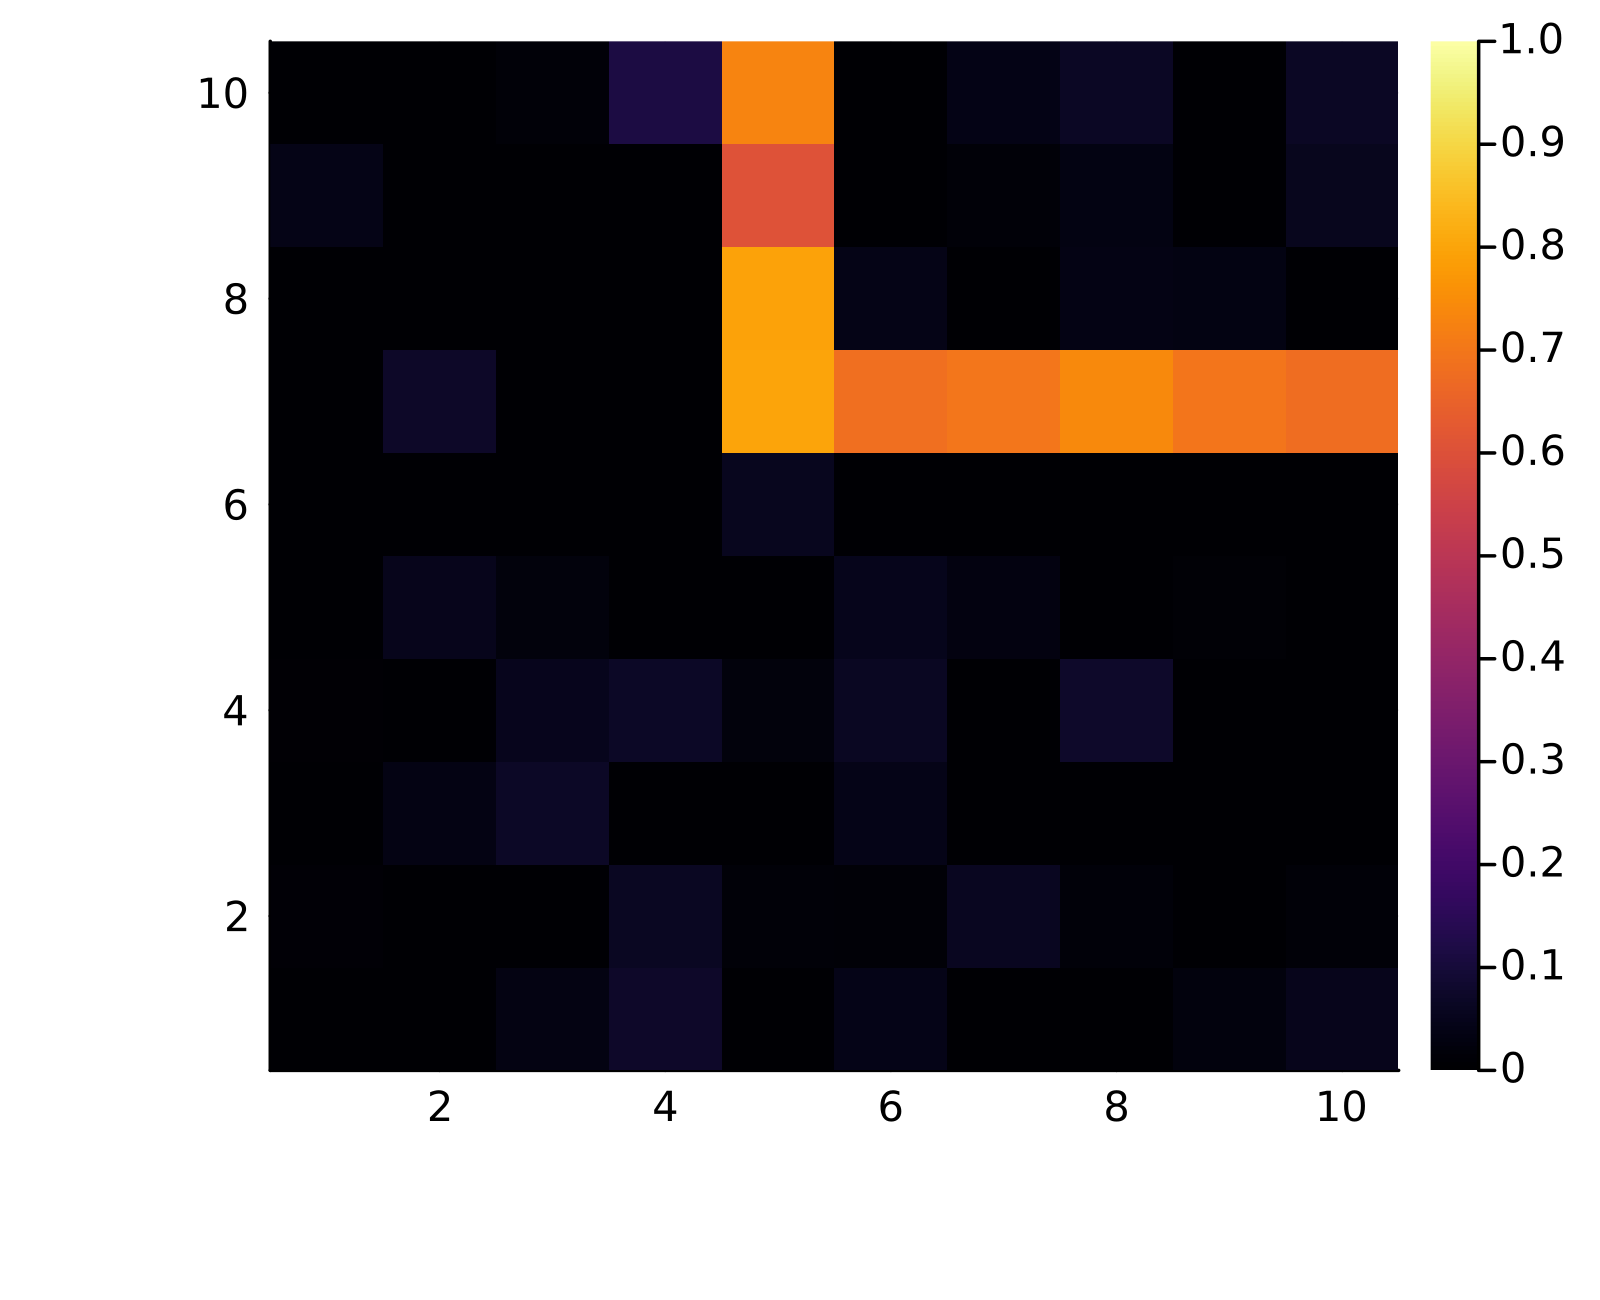

In [74]:
Random.seed!(42)
visualize(two_d_world())

### Q 1B [2 pts]
Now implement an amortized variational approximation of this generative model, parametrized with a deep neural network conditioning this approximation to input observations. You will do this in the generative function `neural_amortized_inference`, below.

Assume that the neural network takes as input a vector &ndash; so, the observations should be flattened to vectors (from 2D matrices). Your network architecture should be rather simple: one hidden layer and one output layer. The hidden layer should be activated with a `tanh` non-linearity (provided in the code block below).

The output layer should consist of all of the variational family parameters. 

As for your variational approximation, for a random variable `x ~ uniform(0,1)` in your generative model (`two_d_world`), a reasonable choice would be `x ~ beta(shape, scale)`. Your neural network would be outputting the parameters of the beta, but you'd need to be careful to ensure that these parameters are possitive. E.g., you can use exp() as the activation function for the output layer: `exp.(x)`. 

HINT: There are 5 (location, size, object brightness) random variables we want to infer based on an observed image. So there should be 10 parameters from the output layer of the neural network (2 parameters for the beta distribution for each random variable).
</details>

In [75]:
σ(x) = tanh.(x)

@gen function neural_amortized_inference(input::Vector{Float64})
    @param W1::Matrix{Float64}
    @param b1::Vector{Float64}

    @param W2::Matrix{Float64}
    @param b2::Vector{Float64}

    # non-linear hidden layer
    hidden_layer = σ(W1 * input + b1)
    
    # output layer
    output_layer = exp.(W2 * hidden_layer + b2)
    
    # feature extraction
    SW_row_shape = output_layer[1]
    SW_row_scale = output_layer[2]

    SW_col_shape = output_layer[3]
    SW_col_scale = output_layer[4]

    w_shape = output_layer[5]
    w_scale = output_layer[6]

    h_shape = output_layer[7]
    h_scale = output_layer[8]

    b_shape = output_layer[9]
    b_scale = output_layer[10]

    SW_row ~ beta(SW_row_shape, SW_row_scale)
    SW_col ~ beta(SW_col_shape, SW_col_scale)
    w ~ beta(w_shape, w_scale)
    h ~ beta(h_shape, h_scale)
    b ~ beta(b_shape, b_scale)
    
    return nothing
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##neural_amortized_inference#245", Bool[0], false)

### Q 1C [1 pts]

Next create a data generator function, called `data_generator`. Notice that this function takes no arguments. In each call, it will simulate the generative model of our world once. This will yield a pair of input and output for training the neural network based estimator `neural_amortized_inference`.

In [76]:
function data_generator()
    tr = Gen.simulate(two_d_world, ())

    # record the "observations" (inputs to the NN model, i.e., brightness of each pixel)
    obs_matrix = Matrix{Float64}(undef, N_ROWS, N_COLS)
    
    for row_id in 1:N_ROWS
        for col_id in 1:N_COLS
            obs_matrix[row_id, col_id] = tr[:image => row_id => col_id => :brightness]
        end
    end
    
    obs = vec(obs_matrix)
    
    # record the random choices of the 5 latent variables (outputs of the NN model)
    constraints = Gen.choicemap()
    constraints[:SW_row] = tr[:SW_row]
    constraints[:SW_col] = tr[:SW_col]
    constraints[:w] = tr[:w]
    constraints[:h] = tr[:h]
    constraints[:b] = tr[:b]
    
    return ((obs,), constraints)
end

data_generator (generic function with 1 method)

### Q 1D [1.5 pts]

Initialize the `params` in the `neural_amortized_inference`. You will have to pay attention to your dimensions.

Choose the dimensionality of the hidden layer to be 200. Use the `init_weight` function (provided in the code block below) to initialize your weight matrices. 

In [77]:
Random.seed!(42)
# a function for randomly initializing the weight matrices
init_weight(shape...) = (1. / sqrt(shape[2])) * randn(shape...)

# input, hidden, and output dimensions of the network
input_dim = 100
hidden_dim = 200
output_dim = 10

# create and initialize W1 and W2
init_W1 = init_weight(hidden_dim, input_dim)
init_W2 = init_weight(output_dim, hidden_dim)

# set params of the data-driven proposal function
init_param!(neural_amortized_inference, :W1, init_W1)
init_param!(neural_amortized_inference, :b1, zeros(hidden_dim))
init_param!(neural_amortized_inference, :W2, init_W2)
init_param!(neural_amortized_inference, :b2, zeros(output_dim));

### Q 1E [1 pt]

Create an optimizer for updating the weights using `Gen.FixedStepGradientDescent` with a learning rate of `1e-5`. 

Train your amortized estimator using this optimizer using `Gen.train!`. 

Use the following arguments for the `train!` function:
```
num_epoch=200
epoch_size=1000
num_minibatch=100
minibatch_size=10
evaluation_size=100
verbose=true
```

In [78]:
# get a gradient-based optimizer and train!
# your code here
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(1e-5), neural_amortized_inference);
Gen.train!(neural_amortized_inference, data_generator, update, num_epoch=200, epoch_size=1000, num_minibatch=100, minibatch_size=10, evaluation_size=100, verbose=true)
# save trained parameters
let data = Dict()
    for name in [:W1, :b1, :W2, :b2]
        data[(:param, name)] = Gen.get_param(neural_amortized_inference, name)
    end
    save("neural_amortized_inference_trained.jld2", "data", data)
end

epoch 1: generating 1000 training examples...
epoch 1: training using 100 minibatches of size 10...
epoch 1: evaluating on 100 examples...
epoch 1: est. objective value: 0.0
epoch 2: generating 1000 training examples...
epoch 2: training using 100 minibatches of size 10...
epoch 2: evaluating on 100 examples...
epoch 2: est. objective value: 0.0
epoch 3: generating 1000 training examples...
epoch 3: training using 100 minibatches of size 10...
epoch 3: evaluating on 100 examples...
epoch 3: est. objective value: 0.0
epoch 4: generating 1000 training examples...
epoch 4: training using 100 minibatches of size 10...
epoch 4: evaluating on 100 examples...
epoch 4: est. objective value: 0.0
epoch 5: generating 1000 training examples...
epoch 5: training using 100 minibatches of size 10...
epoch 5: evaluating on 100 examples...
epoch 5: est. objective value: 0.0
epoch 6: generating 1000 training examples...
epoch 6: training using 100 minibatches of size 10...
epoch 6: evaluating on 100 exa

The following code loads a test observation and visualizes it. 

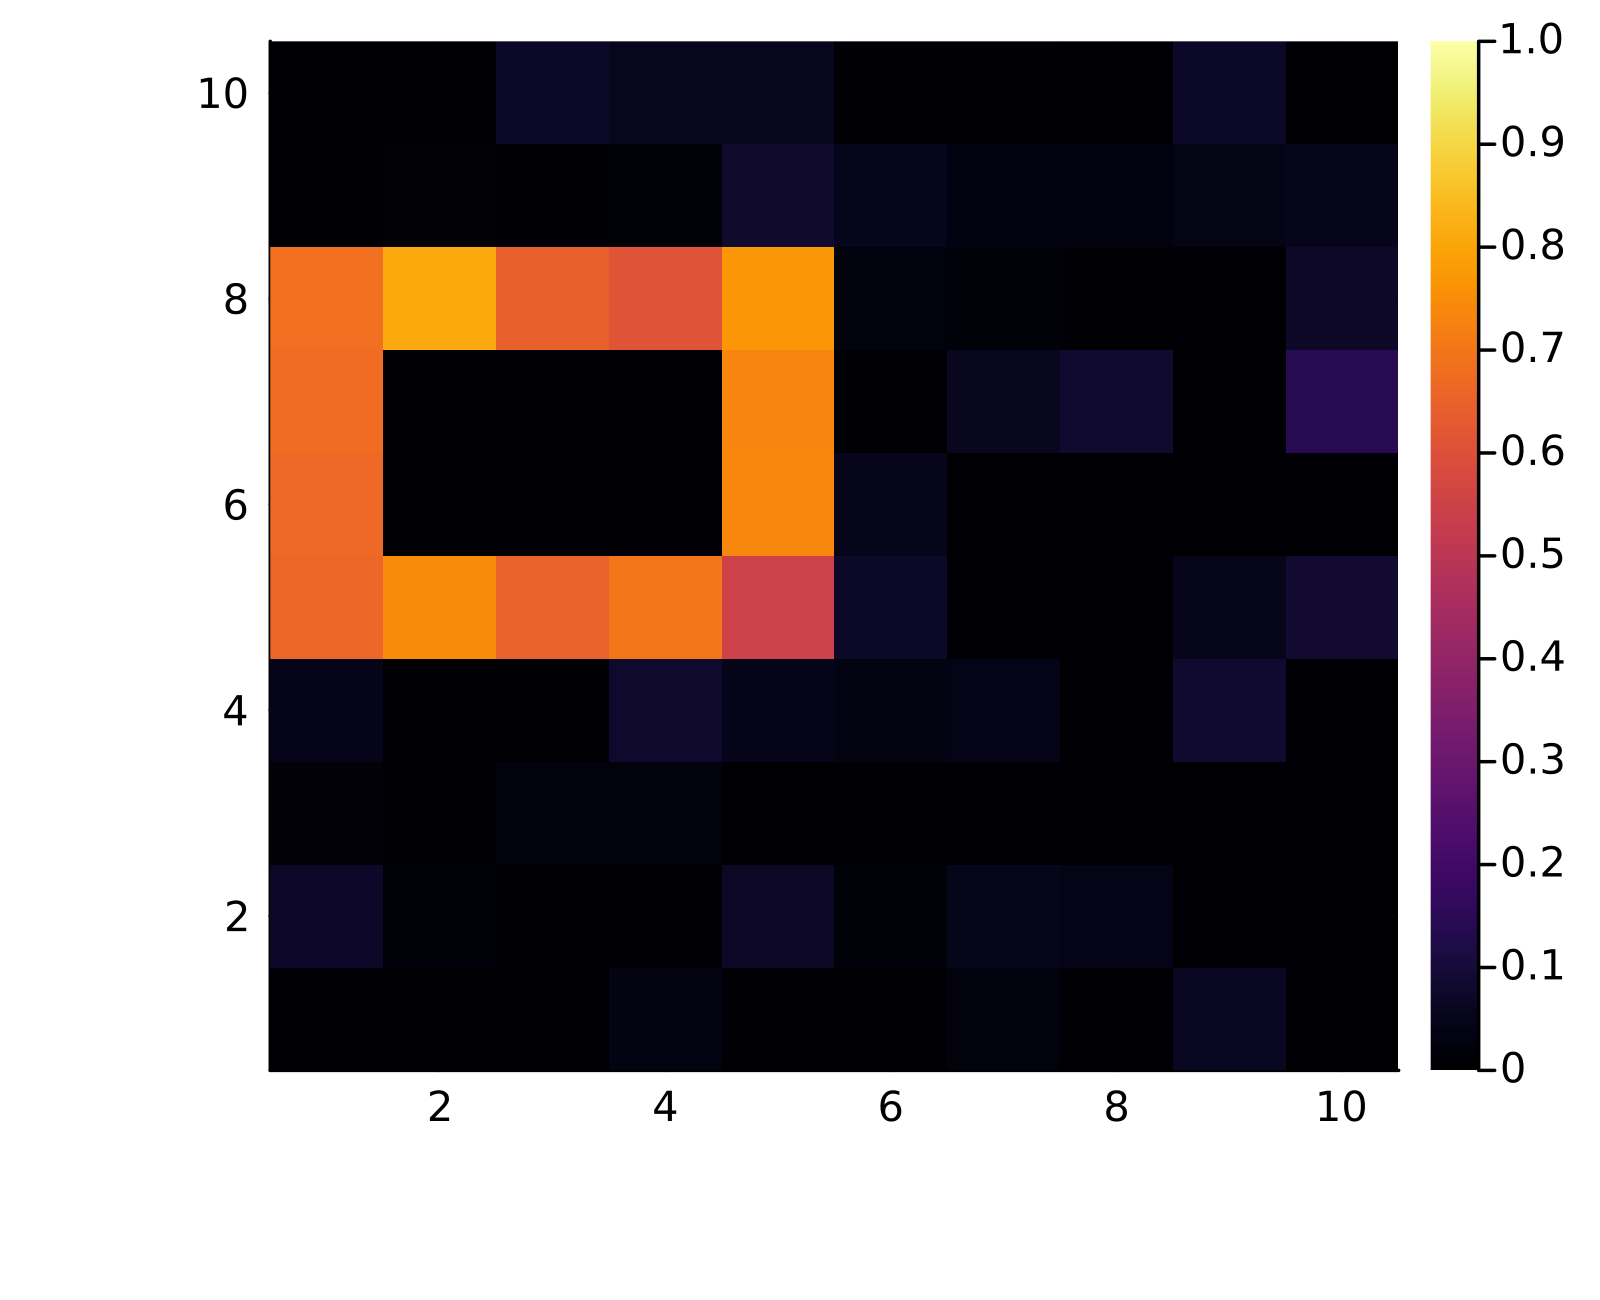

In [79]:
obs_matrix = readdlm("test-scene.txt")
obs = vec(obs_matrix)
obs = convert(Vector{Float64}, obs)
p1 = visualize(obs_matrix)

### Q 1F [2 pts] <a id="q-1f"></a>

Conditioned on this observation, run importance sampling with or without `neural_amortized_inference` as the data-driven proposal. Compare the average log probabilities of the two methods. The importance sampling with `neural_amortized_inference` proposal should have significantly better results.

In [80]:
# load trained parameters
let data = JLD2.load("neural_amortized_inference_trained.jld2", "data")
    for name in [:W1, :b1, :W2, :b2]
        Gen.init_param!(neural_amortized_inference, name, data[(:param, name)])
    end
end;

In [81]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

# Make constraints based on the observed image (obs_matrix)
constraints = Gen.choicemap()
for row_id in 1:N_ROWS
    for col_id in 1:N_COLS
        constraints[:image => row_id => col_id => :brightness] = obs_matrix[row_id, col_id]
    end
end

traces = Vector()
for _ in 1:10
    (trace, _) = importance_resampling(two_d_world, (), constraints, 100)
    push!(traces, trace)
end
        
scores = [get_score(t) for t in traces]

println(logmeanexp(scores))

-340.1912669383046


In [82]:
# run importance sampling *with* the neural amortized inference, amount of compute = 100, repeat 10 times
traces = Vector()
for _ in 1:10
    (trace, _) = importance_resampling(two_d_world, (), constraints, neural_amortized_inference, (vec(obs_matrix),), 100)
    push!(traces, trace)
end

scores = [get_score(t) for t in traces]

println(logmeanexp(scores))

137.1581832966427
